This is a summary and cleaner version of the jupyter lab called: http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_4.ipynb

In this juper lab: 

1. load the projects with all the sessions
2. load cells and mvl around lever 
3. run lstmModel.py and import all functions
4. loop through all sessions with 1 or more than 1 FS and generate the shuffleing df.

Here I mostly wanted to load the result from the shuffeling and check if they worked for the sessions where the shuffling worked .. its in Shuffled_values forder

In [6]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *
from lstmModel import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
#prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions
prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[130:153],myProject.sessionList[130:153]) ### sSeslist >>>> sSessions


Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.67s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [4]:
#for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[130:153],sSessions[130:153])):
    getSearchHomingIntervals(ses, sSes)

2it [00:00, 37.94it/s]


In [7]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)
res = pd.read_csv(fn)
###
#df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 92.1 ms, sys: 12 ms, total: 104 ms
Wall time: 104 ms


In [10]:
def run_evalute_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5): 
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
               
        train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses, cells,interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none")
        
        ### get my model 
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
        #print("Device available:", device)

        #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
        optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss() # 
        model.train()


        ### train the model 
        df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                     optimizer=optimizer,
                     model = model,
                     loss_fn = loss_fn,
                     train_data_loader=train_data_loader,
                     test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                     config=config,
                     device = device,
                     verbose=False)
    
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

        myMetrics= {'session': sSes.name,
                   'df': df, 
                   'mse_test': mse_test, 
                   'outputs_test': outputs_test, 
                    'labels_test': labels_test, 
                    'mse_train': mse_train, 
                    'outputs_train': outputs_train,
                    'labels_train':labels_train,
                    'config': config
               }
        
    else:
        myMetrics=np.nan
    return myMetrics

def Plot_labes_outPuts_from_model(gs,  df,config, labels_test, labels_train, outputs_train, outputs_test, mse_train, mse_test ):
    

    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('n_epochs:{} ' .format(config['num_epochs']), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,1])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,0], outputs_train[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,0], outputs_train[:,0])
    circr= abs(circcorrcoef(labels_train[:,0], outputs_train[:,0])) 

    # plot the identity line
    ax.plot([min(labels_train[:,0]), max(labels_train[:,0])], [min(labels_train[:,0]), max(labels_train[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, SinAngle' .format(r,circr, mse_train[0]), fontsize=9)
    # Add legend
    plt.legend()


    ax= fig.add_subplot(gs[0,2])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,0], outputs_test[:,0], s= 0.2)
    ax.set_xlabel('SinAngle')##
    ax.set_ylabel('predicted SinAngle')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(labels_test[:,0], outputs_test[:,0])
    circr= abs(circcorrcoef(labels_test[:,0], outputs_test[:,0])) 

    # plot the identity line
    ax.plot([min(labels_test[:,0]), max(labels_test[:,0])], [min(labels_test[:,0]), max(labels_test[:,0])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, SinAngle' .format(r,circr, mse_test[0]), fontsize=9)
    # Add legend
    #ax.legend(loc='upper center', bbox_to_anchor=(1, 1.3), fancybox=True, shadow=True)

    ax= fig.add_subplot(gs[0,3])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_train[:,1], outputs_train[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_train[:,1], outputs_train[:,1]) ## labels are the Angles
    circr= circcorrcoef(labels_train[:,1], outputs_train[:,1]) ## outputs are the pred_angles
    # plot the identity line
    ax.plot([min(labels_train[:,1]), max(labels_train[:,1])], [min(labels_train[:,1]), max(labels_train[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Train, CosAngle' .format(r,circr, mse_train[1]), fontsize=9)
    # Add legend


    ax= fig.add_subplot(gs[0,4])
    #sns.kdeplot(labels, outputs)
    ax.scatter(labels_test[:,1], outputs_test[:,1], s= 0.2)
    ax.set_xlabel('Cos_Angles ')##
    ax.set_ylabel('predicted Cos_Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(labels_test[:,1], outputs_test[:,1])
    circr= abs(circcorrcoef(labels_test[:,1], outputs_test[:,1])) 

    # plot the identity line
    ax.plot([min(labels_test[:,1]), max(labels_test[:,1])], [min(labels_test[:,1]), max(labels_test[:,1])], color='red', label=f'Iden. line')
    ax.set_title('r:{:.2f}, circr:{:.2f} \n MSE:{:.2f} \n Test, CosAngle' .format(r,circr, mse_test[1]), fontsize=9)
    # Add legend

    ###########################
    #### plot the original angle vs predicted angle in test and training datasets: 
    #############################

    Angle_train = np.arctan2(labels_train[:,0], labels_train[:,1])
    Angle_train_pred = np.arctan2(outputs_train[:,0], outputs_train[:,1])


    Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])

    ################
    ##################
    ##
    ###############
    ##############
    ax= fig.add_subplot(gs[1,0])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    ax.set_title('Train dataset \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)

    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')


    ax= fig.add_subplot(gs[1,1])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))

    ax.set_title('Test dataset \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')


    ## 
    ax= fig.add_subplot(gs[1,2])
    sns.histplot(Angle_train, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_train_pred, color='r', label='Predi. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Train', fontsize=9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True)


    ax= fig.add_subplot(gs[1,3])
    sns.histplot(Angle_test, color='k', label='Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    sns.histplot(Angle_test_pred, color='r', label='Predic. Angles', kde=False, stat='density', element='step', fill=False, alpha= 0.6)
    ax.set_title('Test. from model', fontsize= 9)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('Counts')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend()

In [11]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'
## RUN THE MODEL
myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)


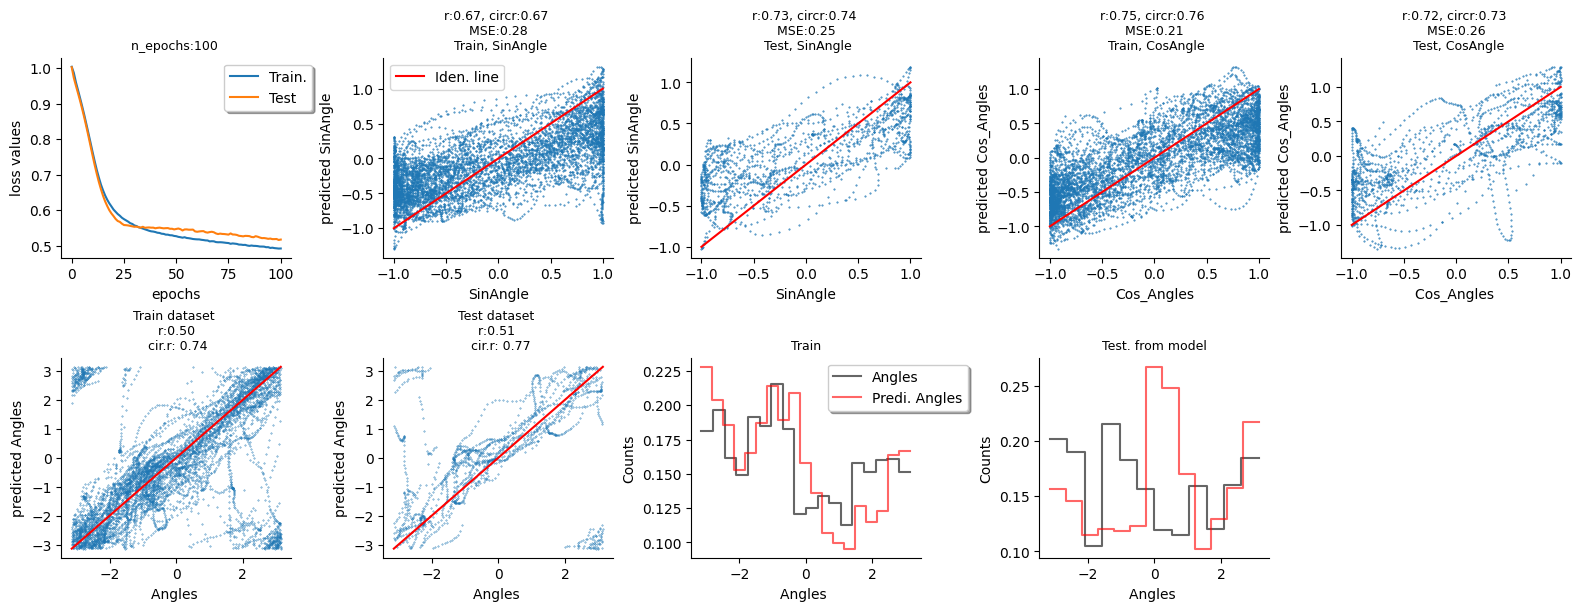

In [18]:
col = 6
row = 2
sizePerRow, sizePerCol = 3, 3
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)


Plot_labes_outPuts_from_model(gs,  myMetrics['df'], myMetrics['config'], myMetrics['labels_test'], myMetrics['labels_train'], myMetrics['outputs_train'], myMetrics['outputs_test']
                              , myMetrics['mse_train'], myMetrics['mse_test'])


## Run the shuffling on all sessions:

In [13]:
from multiprocessing import Pool
from functools import partial
import os
from datetime import datetime
from tqdm import tqdm
import traceback
from concurrent.futures import ProcessPoolExecutor
from lstmModel import *
## SET THIS DIRECTORY ON lstmMODEL.py
save_directory ='/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/100_shuffle/'
os.makedirs(save_directory, exist_ok=True)


iteration = 100


In [14]:
iteration

100

In [16]:
import gc
gc.collect()

0

+ This took 39 hours for 44 sessions for 2 different intervals .. in total 88 sessions around 39 hours


In [20]:
# Track start time
from datetime import datetime
now = datetime.now()
print("Start time:", now.strftime("%d/%m/%Y %H:%M:%S"))
interNames = ['atLever_light', 'atLever_dark']
# Run in parallel using Pool
with Pool(4) as pool:
    # Use partial to pass fixed arguments to the wrapper function
    process_func = partial(process_session_wrapper, interNames=interNames, cells=cells, iteration=iteration)
    
    # Zip the two session lists and process each session pair in parallel
    session_pairs = list(zip(sSessions[:], myProject.sessionList[:])) 
    #session_pairs = list(zip(sSessions[131:132], myProject.sessionList[131:132]))
    pool.map(process_func, session_pairs)

# Track end time
now = datetime.now()
print("End time:", now.strftime("%d/%m/%Y %H:%M:%S"))



Start time: 18/11/2024 13:16:30
File mn8578-05122021-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-05122021-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File mn8578-06122021-0107_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-06122021-0107_atLever_dark_shuffled_values.pkl already exists. Skipping.
File mn8578-07122021-0107_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-07122021-0107_atLever_dark_shuffled_values.pkl already exists. Skipping.
File mn8578-08122021-0110_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-08122021-0110_atLever_dark_shuffled_values.pkl already exists. Skipping.
File mn8578-10122021-0107_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-10122021-0107_atLever_dark_shuffled_values.pkl already exists. Skipping.
File mn8578-15122021-0107_atLever_light_shuffled_values.pkl already exists. Skipping.
File mn8578-15122021-0107_a

  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]

File jp3269-29112022-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp3269-29112022-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp3269-28112022-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp3269-28112022-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp3269-27112022-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp3269-27112022-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp3269-30112022-0110_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp3269-30112022-0110_atLever_dark_shuffled_values.pkl already exists. Skipping.
jp3269-25112022-0108


  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]

File jp486-13032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-13032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-16032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-16032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-26032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-26032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-18032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-18032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-22032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-22032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-24032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-24032023-0108_atLever_dark_shuffled_values.pkl already exis

  0%|                                                                                                    | 0/100 [00:00<?, ?it/s]

File jp487-07022023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp487-07022023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp487-12022023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
jp487-12022023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:59:20<00:00, 71.61s/it]


Saved data for jp3269-25112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-25112022-0108_atLever_light_shuffled_values.pkl
jp3269-25112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:01:22<00:00, 72.83s/it]


Saved data for jp452-22112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-22112022-0108_atLever_dark_shuffled_values.pkl
jp452-14112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:11:35<00:00, 78.96s/it]


Saved data for jp487-09022023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-09022023-0108_atLever_dark_shuffled_values.pkl
jp487-10022023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:19:01<00:00, 83.41s/it]


Saved data for jp487-12022023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-12022023-0108_atLever_dark_shuffled_values.pkl
jp487-06022023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:14:56<00:00, 44.96s/it]


Saved data for jp452-14112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-14112022-0108_atLever_light_shuffled_values.pkl
jp452-14112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:20<00:00, 41.61s/it]


Saved data for jp487-06022023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-06022023-0108_atLever_light_shuffled_values.pkl
jp487-06022023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:25:03<00:00, 51.03s/it]


Saved data for jp487-10022023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-10022023-0108_atLever_light_shuffled_values.pkl
jp487-10022023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:48:27<00:00, 65.07s/it]


Saved data for jp3269-25112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-25112022-0108_atLever_dark_shuffled_values.pkl
jp3269-23112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:29:26<00:00, 53.67s/it]


Saved data for jp452-14112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-14112022-0108_atLever_dark_shuffled_values.pkl
jp452-24112022-0109


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:44:17<00:00, 62.57s/it]


Saved data for jp487-06022023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-06022023-0108_atLever_dark_shuffled_values.pkl
jp497-06052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:40:55<00:00, 60.56s/it]


Saved data for jp487-10022023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp487-10022023-0108_atLever_dark_shuffled_values.pkl
jp497-08052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:39:15<00:00, 59.55s/it]


Saved data for jp3269-23112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-23112022-0108_atLever_light_shuffled_values.pkl
jp3269-23112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:29:54<00:00, 53.94s/it]


Saved data for jp452-24112022-0109_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-24112022-0109_atLever_light_shuffled_values.pkl
jp452-24112022-0109


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:12:34<00:00, 43.54s/it]


Saved data for jp497-06052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-06052023-0108_atLever_light_shuffled_values.pkl
jp497-06052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:16:07<00:00, 45.68s/it]


Saved data for jp497-08052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-08052023-0108_atLever_light_shuffled_values.pkl
jp497-08052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:05:59<00:00, 75.60s/it]


Saved data for jp3269-23112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-23112022-0108_atLever_dark_shuffled_values.pkl
jp3269-26112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:27:30<00:00, 52.50s/it]


Saved data for jp497-06052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-06052023-0108_atLever_dark_shuffled_values.pkl
jp497-04052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:50:16<00:00, 66.16s/it]


Saved data for jp452-24112022-0109_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-24112022-0109_atLever_dark_shuffled_values.pkl
jp452-15112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:55:36<00:00, 69.36s/it]


Saved data for jp497-08052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-08052023-0108_atLever_dark_shuffled_values.pkl
jp499-15052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:23:24<00:00, 50.05s/it]


Saved data for jp452-15112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-15112022-0108_atLever_light_shuffled_values.pkl
jp452-15112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:36:51<00:00, 58.12s/it]


Saved data for jp497-04052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-04052023-0108_atLever_light_shuffled_values.pkl
jp497-04052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:12:39<00:00, 79.60s/it]


Saved data for jp3269-26112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-26112022-0108_atLever_light_shuffled_values.pkl
jp3269-26112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:42:47<00:00, 61.67s/it]


Saved data for jp499-15052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-15052023-0108_atLever_light_shuffled_values.pkl
jp499-15052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:22:44<00:00, 49.65s/it]


Saved data for jp452-15112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-15112022-0108_atLever_dark_shuffled_values.pkl
jp452-12112022-0109


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:35:13<00:00, 93.13s/it]


Saved data for jp497-04052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-04052023-0108_atLever_dark_shuffled_values.pkl
jp497-05052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:36:33<00:00, 57.94s/it]


Saved data for jp452-12112022-0109_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-12112022-0109_atLever_light_shuffled_values.pkl
jp452-12112022-0109


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:43:42<00:00, 98.23s/it]


Saved data for jp3269-26112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp3269-26112022-0108_atLever_dark_shuffled_values.pkl
File jp486-14032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-14032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-27032023-0110_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-27032023-0110_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-20032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-20032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp486-15032023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp486-15032023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:56:21<00:00, 105.82s/it]


Saved data for jp499-15052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-15052023-0108_atLever_dark_shuffled_values.pkl
File jp499-22052023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp499-22052023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
jp499-19052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:08:18<00:00, 40.98s/it]


Saved data for jp497-05052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-05052023-0108_atLever_light_shuffled_values.pkl
jp497-05052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:20:20<00:00, 48.21s/it]


Saved data for jp452-12112022-0109_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-12112022-0109_atLever_dark_shuffled_values.pkl
jp452-17112022-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:15:52<00:00, 45.53s/it]


Saved data for jp497-05052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-05052023-0108_atLever_dark_shuffled_values.pkl
File jp497-30042023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp497-30042023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
jp497-07052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:25:26<00:00, 51.26s/it]


Saved data for jp499-19052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-19052023-0108_atLever_light_shuffled_values.pkl
jp499-19052023-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [57:22<00:00, 34.42s/it]


Saved data for jp452-17112022-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-17112022-0108_atLever_light_shuffled_values.pkl
jp452-17112022-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:09<00:00, 32.49s/it]


Saved data for jp497-07052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-07052023-0108_atLever_light_shuffled_values.pkl
jp497-07052023-0108


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:15:20<00:00, 45.21s/it]


Saved data for jp452-17112022-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp452-17112022-0108_atLever_dark_shuffled_values.pkl


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:34:40<00:00, 56.81s/it]


Saved data for jp499-19052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-19052023-0108_atLever_dark_shuffled_values.pkl
File jp499-26052023-0110_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp499-26052023-0110_atLever_dark_shuffled_values.pkl already exists. Skipping.
jp499-17052023-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:59<00:00, 32.99s/it]


Saved data for jp497-07052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp497-07052023-0108_atLever_dark_shuffled_values.pkl


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [57:12<00:00, 34.33s/it]


Saved data for jp499-17052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-17052023-0108_atLever_light_shuffled_values.pkl
jp499-17052023-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [53:54<00:00, 32.34s/it]


Saved data for jp499-17052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-17052023-0108_atLever_dark_shuffled_values.pkl
File jp499-23052023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp499-23052023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
File jp499-24052023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp499-24052023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
jp499-18052023-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [38:02<00:00, 22.82s/it]


Saved data for jp499-18052023-0108_atLever_light_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-18052023-0108_atLever_light_shuffled_values.pkl
jp499-18052023-0108


100%|██████████████████████████████████████████████████████████████████████████████████████████| 100/100 [43:58<00:00, 26.38s/it]


Saved data for jp499-18052023-0108_atLever_dark_shuffled_values.pkl at /home/kevin/repo/autopi_inter_new/autopi_interneuron_decoding/notebooks/Shuffled_100/jp499-18052023-0108_atLever_dark_shuffled_values.pkl
File jp499-25052023-0108_atLever_light_shuffled_values.pkl already exists. Skipping.
File jp499-25052023-0108_atLever_dark_shuffled_values.pkl already exists. Skipping.
End time: 19/11/2024 08:38:32


In [17]:
print(torch.__version__)      # PyTorch version
print(torch.version.cuda)     # CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Check if CUDA is available

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

1.11.0+cu102
10.2
True
